# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - The Dataset contains 1458644 trip records


### Data fields
* #### id - A unique identifier for each trip.
* #### vendor_id - A code indicating the provider associated with the trip record.
* #### pickup_datetime - Date and time when the meter was engaged.
* #### dropoff_datetime - Date and time when the meter was disengaged.
* #### passenger_count - The number of passengers in the vehicle. (driver entered value)
* #### pickup_longitude - The longitude where the meter was engaged.
* #### pickup_latitude - The latitude where the meter was engaged.
* #### dropoff_longitude - The longitude where the meter was disengaged.
* #### dropoff_latitude - The latitude where the meter was disengaged.
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.
* #### trip_duration - Duration of the trip in seconds. (Target variable)


# **Import libraries**

In [ ]:
#Importing the libraries which will be required for this project.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#**Mount Google Drive**

In [ ]:
 
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# **Import Dataset**

In [ ]:
data= pd.read_csv("/content/drive/MyDrive/NYC Taxi Data.csv")

# **Data Overview**

View our data set.

In [ ]:
data.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


Checking number of rows and columns in our dataset.

In [ ]:
print("Number of rows is: ", data.shape[0])
print("Number of columns is: ", data.shape[1])

Number of rows is:  1458644
Number of columns is:  11


Let's look at each feture in our dataset.

In [ ]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

Check the number of unique id in our dataset


In [ ]:
print( 'We have %d unique id in our dataset ' %(data.id.nunique()))

We have 1458644 unique id in our dataset 


Check any NAN/NULL records present in our dataset.


In [ ]:
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There is no NAN/NULL values in our dataset.

Let us now look at the datatypes of all features.

In [ ]:
data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

We have pickup_datetime, dropoff_datetime of the type 'object'. Convert it into type 'datetime'.

In [ ]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# **Feature Creation**

Now, let us extract and create new features from this datetime features we just created.

In [ ]:
data['pickup_weekday']=data['pickup_datetime'].dt.day_name()

In [ ]:
data['dropoff_weekday']=data['dropoff_datetime'].dt.day_name()

In [ ]:
data['pickup_weekday_num']=data['pickup_datetime'].dt.weekday

In [ ]:
data['pickup_hour']=data['pickup_datetime'].dt.hour

In [ ]:
data['month']=data['pickup_datetime'].dt.month

We have created the following features:

*   pickup_weekday which will contain the name of the day on which the 
ride was taken.
*   pickup_weekday_num which will contain the day number instead of characters with Monday=0 and Sunday=6.

*   pickup_hour with an hour of the day in the 24-hour format.
*   pickup_month with month number with January=1 and December=12.

We saw in our dataset that we have coordinates in the form of longitude and latitude for pickup and dropoff. But, we can’t really gather any insights or draw conclusions from that.
So, the most obvious feature that we can extract from this is distance. Let us do that.

Importing the library which lets us calculate distance from geographical coordinates.

In [ ]:
from geopy.distance import great_circle

In [ ]:
def cal_distance(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
 
 start_coordinates=(pickup_lat,pickup_long)
 stop_coordinates=(dropoff_lat,dropoff_long)
 
 return great_circle(start_coordinates,stop_coordinates).km

Finally, applying the function to our dataset and creating the feature ‘distance’.

In [ ]:
data['distance'] = data.apply(lambda x: cal_distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude'] ), axis=1)

Calculate Speed in km/h for further insights

In [ ]:
data['speed'] = (data.distance/(data.trip_duration/3600))

Let us check the data type of all features.

In [ ]:
data.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
pickup_weekday                object
dropoff_weekday               object
pickup_weekday_num             int64
pickup_hour                    int64
month                          int64
distance                     float64
speed                        float64
dtype: object

Next, we have defined a function that lets us determine what time of the day the ride was taken. 

We have created four parts of time:-

**1.Morning** (from 6:00 am to 11:59 pm), 

**2.Afternoon** (from 12 noon to 3:59 pm), 

**3.Evening** (from 4:00 pm to 9:59 pm), and 

**4.Late Night** (from 10:00 pm to 5:59 am)

In [ ]:
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'

Now let us apply this function and create new columns in the dataset.

In [ ]:
data['pickup_timeofday']=data['pickup_hour'].apply(time_of_day)

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,dropoff_weekday,pickup_weekday_num,pickup_hour,month,distance,speed,pickup_timeofday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,0,17,3,1.498523,11.856445,Evening
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,0,6,1.805510,9.803673,Late night
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,1,11,1,6.385108,10.822216,Morning
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,2,19,4,1.485501,12.465739,Evening
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,5,13,3,1.188590,9.836608,Afternoon


Now our dataset is complete for the further analysis before we train our model with optimal variables.

# **Univariate Analysis**

The univariate analysis involves studying patterns of all variables individually.

**Target Variable**

Let us start with the target varibale i.e trip duration.

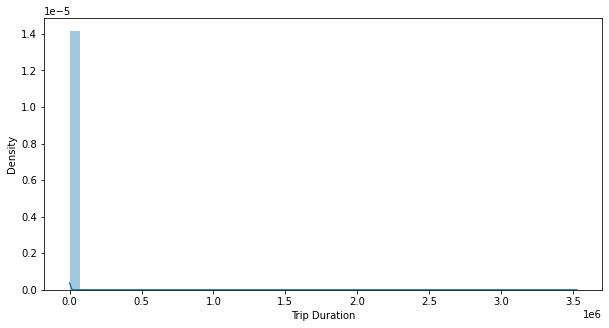

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(data['trip_duration'])
plt.xlabel('Trip Duration')
 
plt.show()

This histogram shows right skewness, hence let's apply the log10 to transform it to the normal distribution.


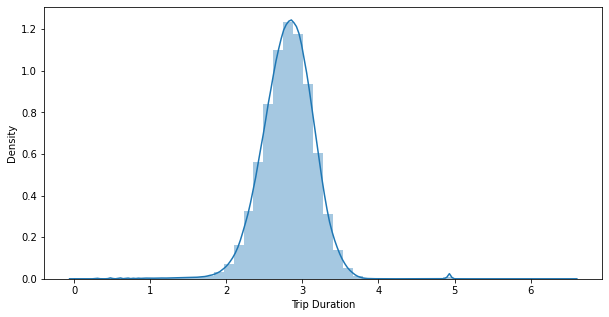

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(np.log10(data['trip_duration']))
plt.xlabel('Trip Duration')
plt.show()


*   Here, we can see that trip_duration is normally distributed.

There are some outliers. Lets see the boxplot of this variable.

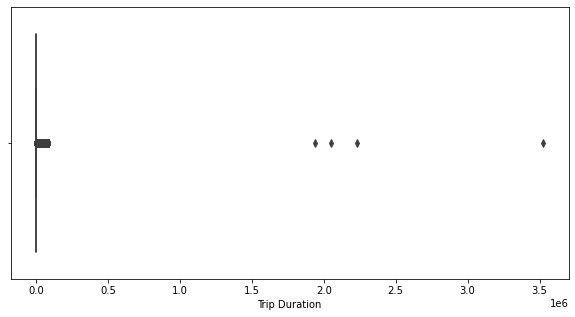

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(data.trip_duration)
plt.xlabel('Trip Duration')
plt.show()

*   We can clearly see an outlier and should be removed for the data consistency.


Calclating 0-100th percentille to find a correct percentile value for removal of outliers.

In [ ]:
for i in range(0,100,10):
  duration= data['trip_duration'].values
  duration= np.sort(duration, axis= None)
  print("{} percentile value is {}".format(i, duration[int(len(duration)*(float(i)/100))]))
print("100 percentile value is ",duration[-1])

0 percentile value is 1
10 percentile value is 245
20 percentile value is 348
30 percentile value is 446
40 percentile value is 548
50 percentile value is 662
60 percentile value is 798
70 percentile value is 968
80 percentile value is 1208
90 percentile value is 1634
100 percentile value is  3526282


*   The 90th percentile i.e. 1634 looks reasonable. But, 100th percentile i.e. 3526282 is outlier. Hence removing these would be a better idea.

Let's expand from 90th percentile to 100th percentile as to look further for the 99th percentile.

In [ ]:
for i in range(90,100):
  duration= data['trip_duration'].values
  duration= np.sort(duration, axis= None)
  print("{} percentile value is {}".format(i, duration[int(len(duration)*(float(i)/100))]))
print("100 percentile value is ",duration[-1])

90 percentile value is 1634
91 percentile value is 1703
92 percentile value is 1780
93 percentile value is 1869
94 percentile value is 1975
95 percentile value is 2104
96 percentile value is 2273
97 percentile value is 2497
98 percentile value is 2829
99 percentile value is 3440
100 percentile value is  3526282


Let's visualize the number of trips taken in slabs of 0-10, 20-30 ... minutes respectively

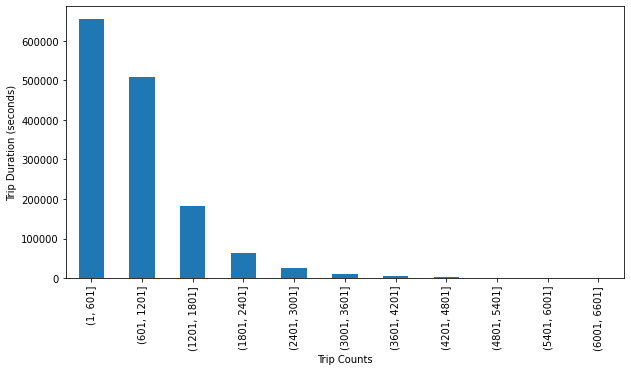

In [ ]:
plt.figure(figsize = (10,5))
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,7200,600))).count().plot(kind='bar')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

Let's have a look at the 10 largest and smallest value of trip_duration.

In [ ]:
print( data['trip_duration'].nlargest(10))

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
295382       86391
73816        86390
59891        86387
1360439      86385
753765       86379
Name: trip_duration, dtype: int64


In [ ]:
print( data['trip_duration'].nsmallest(10))

35196     1
207497    1
269418    1
279493    1
285635    1
311745    1
346102    1
346959    1
404610    1
451396    1
Name: trip_duration, dtype: int64


*   We can see that major chunk (99th percentile) of trip duration is completed in 3440 seconds i.e. nearly 1 hour. 

*   There are very few trip which have duration greater than 5000 seconds.

*   There are some durations with as low as 1 second. which points towards trips with 0 km distance.



We should get rid the outliers for the sake of data consistency. (Trip duration greater than 5000 seconds and also trip duration less than 30 seconds)

In [ ]:
data = data[data.trip_duration <= 5000]
data = data[data.trip_duration >= 30]

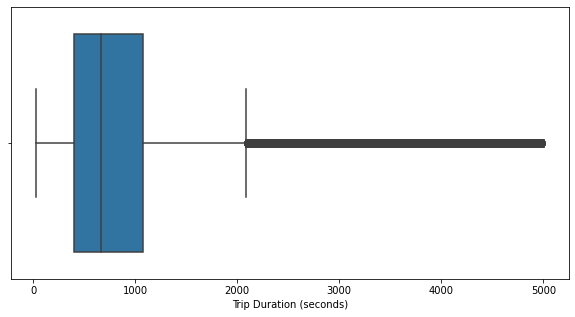

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(data.trip_duration)
plt.xlabel('Trip Duration (seconds)')
plt.show()

*   Major trip durations took between 10-20 mins to complete.
*   We can observe that most of the trips took 0 - 30 mins to complete i.e. approx 1800 secs. Let's move ahead to next feature.



**Trips per Time of Day**

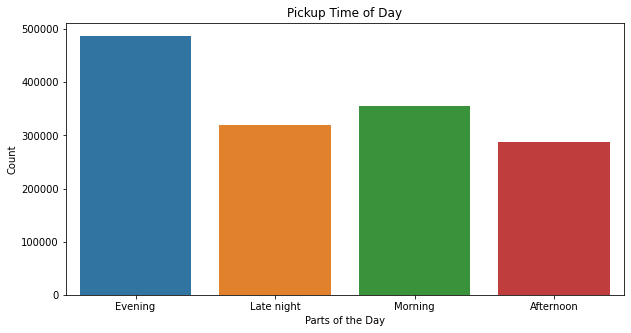

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(x="pickup_timeofday",data=data)
plt.title('Pickup Time of Day')
plt.xlabel('Parts of the Day')
plt.ylabel('Count')
plt.show()

*   As we saw above, evenings are the busiest.


**Vendor id**

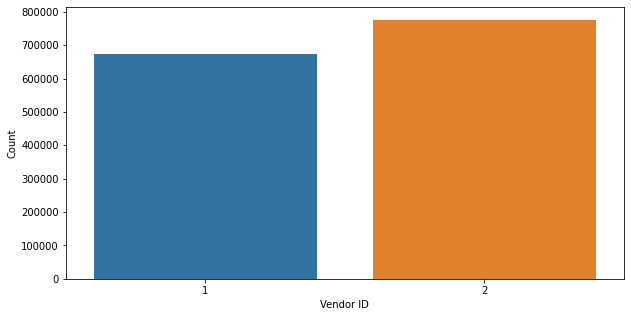

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(data.vendor_id)
plt.xlabel('Vendor ID')
plt.ylabel('Count')
plt.show()

We see that there is not much difference between the trips taken by both vendors.

**Passenger count**

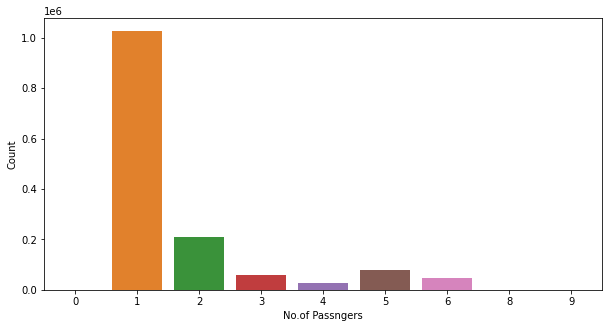

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(x='passenger_count',data=data)
plt.ylabel('Count')
plt.xlabel('No.of Passngers')
plt.show()

Let us remove the rows which have 0 or 7 or 9 passenger count.

In [ ]:
data=data[data['passenger_count']!=0]
data=data[data['passenger_count']<=6]

Let's visualize it again.

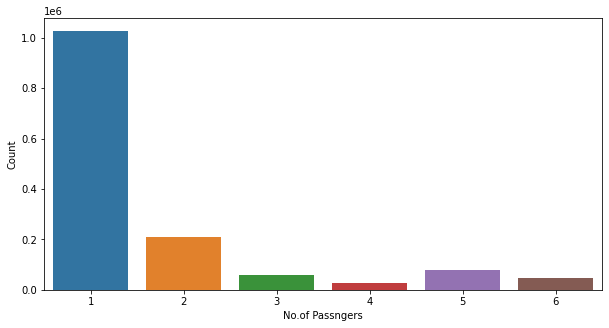

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(x='passenger_count',data=data)
plt.ylabel('Count')
plt.xlabel('No.of Passngers')
plt.show()

*   We see the highest amount of trips was taken by a single passenger.
*   The instance of large group of people travelling together is rare.




Let's check the dataset again.

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,dropoff_weekday,pickup_weekday_num,pickup_hour,month,distance,speed,pickup_timeofday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,0,17,3,1.498523,11.856445,Evening
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,0,6,1.805510,9.803673,Late night
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,1,11,1,6.385108,10.822216,Morning
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,2,19,4,1.485501,12.465739,Evening
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,5,13,3,1.188590,9.836608,Afternoon


**Store and Forward Flag**

In [ ]:
data['store_and_fwd_flag'].value_counts(normalize=True)

N    0.994549
Y    0.005451
Name: store_and_fwd_flag, dtype: float64

*   We can see that only about 1% of the trip details were stored in the vehicle memory first before sending it to the server. 

*   This might have occured because of the GPS or mobile device battery was down when the trip finished.





**Distance**

In [ ]:
data['distance'].value_counts()

0.000000    4555
0.000424      19
0.000424      13
0.001273       9
0.000424       7
            ... 
1.702934       1
4.022746       1
3.667433       1
2.840317       1
3.581178       1
Name: distance, Length: 1445407, dtype: int64

Let's look at the boxplot.

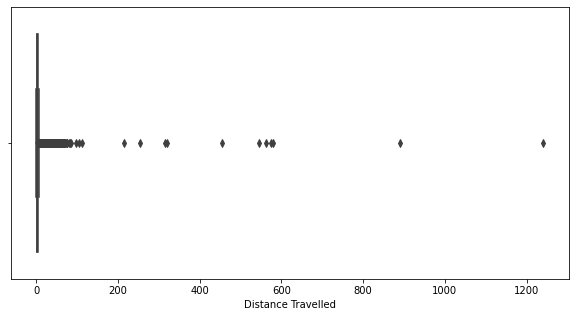

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(data.distance)

plt.xlabel('Distance Travelled')
plt.show()

*   There are some trips with over 100 km distance.
*   Some of the trips with 0 km distance.

The possible reasons for 0 km trips can be:
*   The dropoff location couldn’t be tracked.
*   The driver deliberately took this ride to complete a target ride number.
*   The passengers or driver cancelled the trip due to some issue.
*   Due to some technical issue in software, etc.

Remove the outliers and update the value

In [ ]:
data = data[~(data.distance > 100)]
data = data[~(data.distance < 1)]

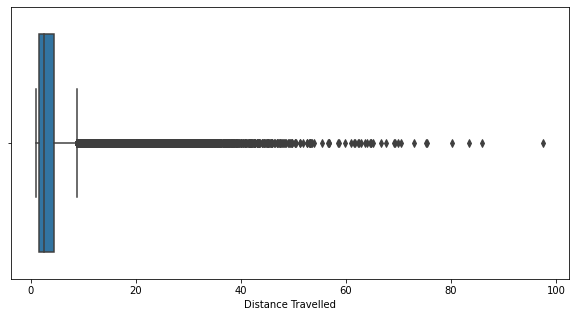

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(data.distance)
plt.xlabel('Distance Travelled')
plt.show()

**Speed**

In [ ]:
data['speed'].value_counts()

9.580937     2
16.180338    1
14.798470    1
34.663723    1
13.539540    1
            ..
10.918117    1
18.773963    1
8.887311     1
18.987874    1
14.245843    1
Name: speed, Length: 1209265, dtype: int64

In [ ]:
data['speed'].nlargest(10)

906281     1408.106827
693299      583.735137
1359910     564.208013
218935      520.505501
500725      424.861414
473439      356.616642
191997      318.580003
793555      270.595438
1328401     255.419847
176589      226.716083
Name: speed, dtype: float64

Let's plot the boxplot for better understanding.

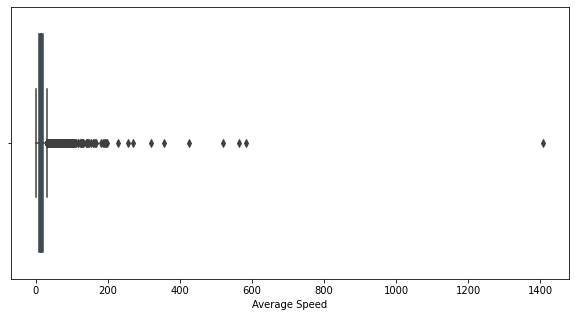

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(data.speed)
plt.xlabel('Average Speed')
plt.show()

*   There are trips that were done at a speed of over 100 km/h.





As per the rule in NYC,  the speed limit is 25 mph(approx. 40km/h) in New York City unless another limit is posted. So having average speed of over 60km/h is quite unreasonable.

In [ ]:
data = data[~(data.speed >60)]

Lets take a look at the smallest speeds as well.

In [ ]:
print( data['speed'].nsmallest(10))

1165873    0.777462
24426      0.825900
1025910    0.877407
1440074    0.900916
1453671    0.913801
440689     0.954780
210725     0.962457
985326     0.988256
623249     0.991219
251672     0.998664
Name: speed, dtype: float64


This shows there are speeds which are less than 1 km/hr for a trip which again is quite unreasonable.

In [ ]:
data = data[~(data.speed <1)]

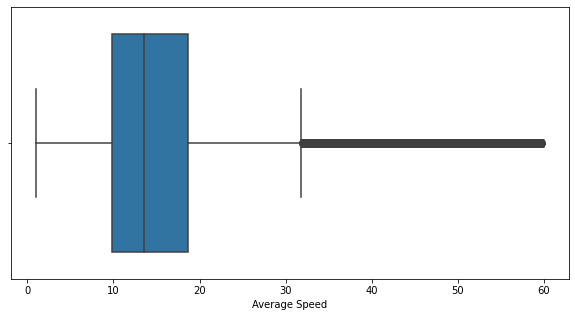

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(data.speed)
plt.xlabel('Average Speed')
plt.show()


Let's take a look at the speed range ditribution with the help of graph.

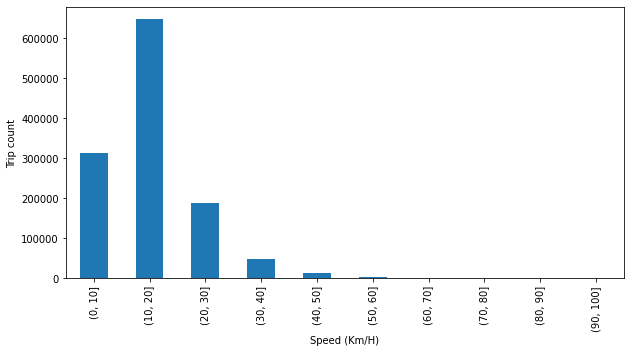

In [ ]:
plt.figure(figsize = (10,5))
data.speed.groupby(pd.cut(data.speed, np.arange(0,104,10))).count().plot(kind = 'bar')
plt.ylabel('Trip count')
plt.xlabel('Speed (Km/H)')
plt.show()

*   Mostly trips are done at a speed range of 10-20 km/h.



**Trips per hour** 

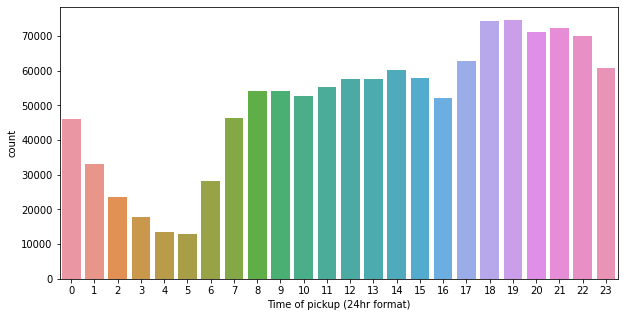

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(data.pickup_hour)
plt.xlabel('Time of pickup (24hr format)')
plt.show()

*   We see the busiest hours are 6:00 pm to 7:00 pm which makes sense as this is the time for people to return home from work.



**Trips per week day**

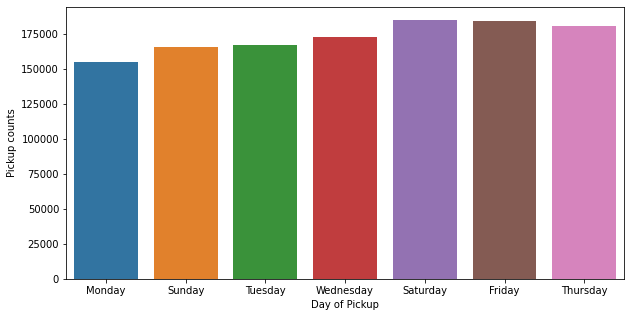

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(data.pickup_weekday)
plt.xlabel('Day of Pickup')
plt.ylabel('Pickup counts')
plt.show()

*   We see Fridays are the busiest days followed by Saturdays. That is probably
because it’s weekend.



**Trips per month**

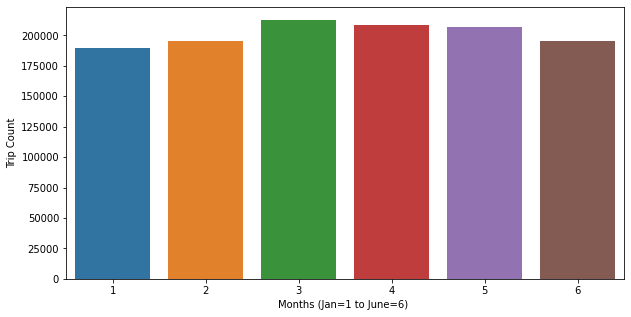

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(data.month)
plt.ylabel('Trip Count')
plt.xlabel('Months (Jan=1 to June=6) ')
plt.show()

*   There is not much difference in the number of trips across months.


# **Bivariate Analysis**

**Trip Duration per Vendor**

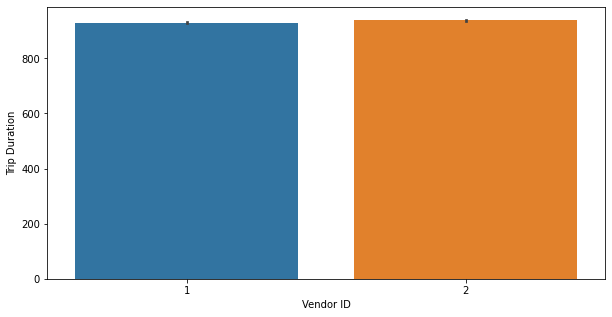

In [ ]:
plt.figure(figsize = (10,5))
sns.barplot(y='trip_duration',x='vendor_id',data=data,estimator=np.mean)
plt.xlabel('Vendor ID')
plt.ylabel('Trip Duration')
plt.show()

*   Vendor id 2 takes longer trips as compared to vendor 1.

**Trip Duration per Store and Forward Flagt**

<Figure size 720x360 with 0 Axes>

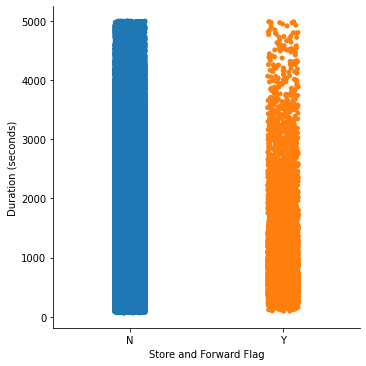

In [ ]:
plt.figure(figsize = (10,5))
sns.catplot(y='trip_duration',x='store_and_fwd_flag',data=data,kind='strip')
plt.xlabel('Store and Forward Flag')
plt.ylabel('Duration (seconds)')
plt.show()



*   There isn't much difference beteen N and Y i.e.stored flags.



**Trip Duration per hour**

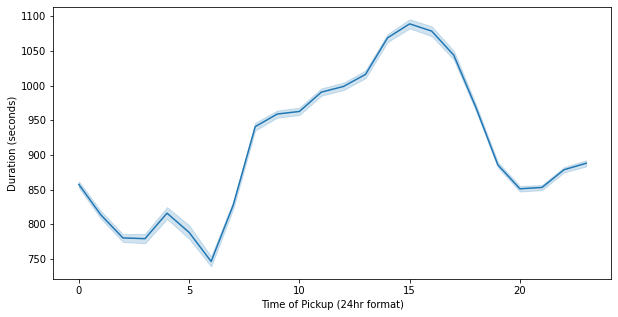

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x='pickup_hour',y='trip_duration',data=data)
plt.xlabel('Time of Pickup (24hr format)')
plt.ylabel('Duration (seconds)')
plt.show()

*   We see the trip duration is the maximum around 3 pm which may be because of traffic on the roads.
*   Trip duration is the lowest around 6 am as streets may not be busy.

**Trip duration per weekday**

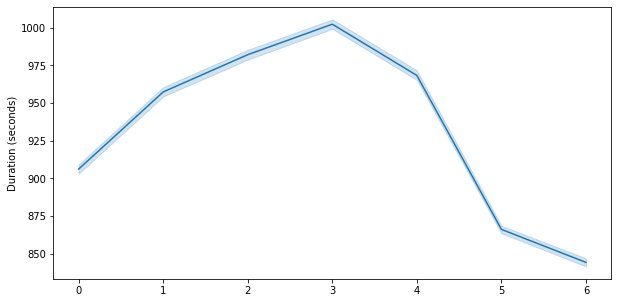

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x='pickup_weekday_num',y='trip_duration',data=data)
plt.ylabel('Duration (seconds)')
plt.xlabel('')
plt.show()

*   Trip duration on thursday is longest among all days.

**Trip duration per month**

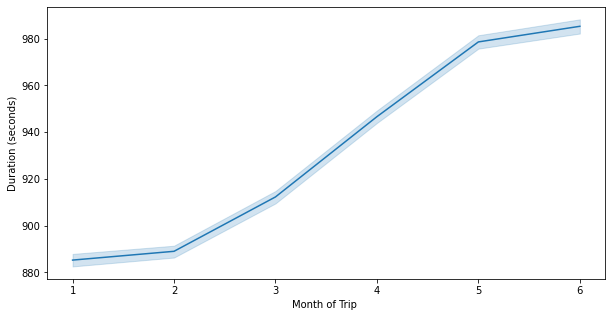

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x='month',y='trip_duration', data=data)
plt.ylabel('Duration (seconds)')
plt.xlabel('Month of Trip ')

plt.show()

*   From February, we can see trip duration rising every month.
*   There might be some seasonal parameters like wind/rain which can be a factor of this gradual increase in trip duration over a period. 



**Distance and Vendor**

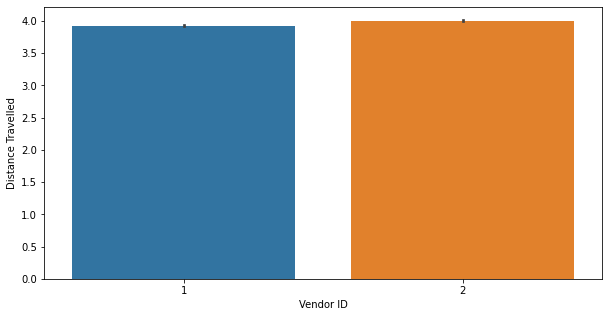

In [ ]:
plt.figure(figsize = (10,5))
sns.barplot(y='distance',x='vendor_id',data=data,estimator=np.mean)
plt.ylabel('Distance Travelled')
plt.xlabel('Vendor ID')
plt.show()

*   The distribution for both vendors is very similar.



**Distance and Store and Forward Flag**

<Figure size 720x360 with 0 Axes>

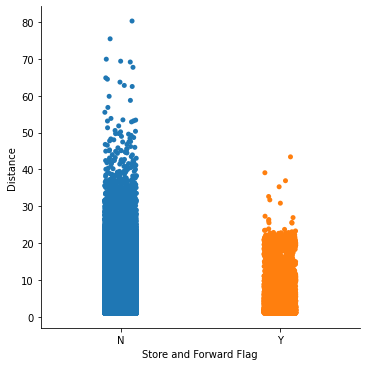

In [ ]:
plt.figure(figsize = (10,5))
sns.catplot(y='distance',x='store_and_fwd_flag',data=data,kind='strip')
plt.ylabel('Distance')
plt.xlabel('Store and Forward Flag')
plt.show()

*   We see for longer distances the trip is not stored.

**Distance and Hour**

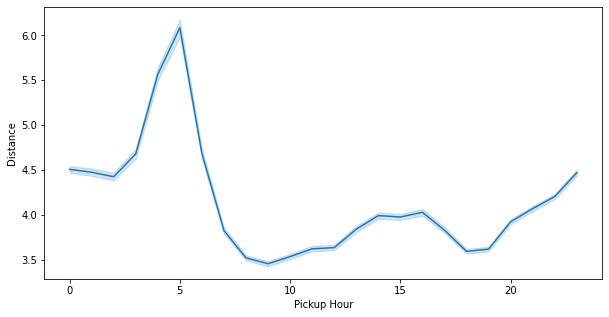

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(y='distance',x='pickup_hour',data=data)
plt.ylabel('Distance')
plt.xlabel('Pickup Hour')
plt.show()

*   Trip distance is highest during early morning hours.
*   It is fairly equal from morning till the evening varying around 3 - 3.5 kms.
*   It starts increasing gradually towards the late night hours starting from evening till 5 AM and decrease steeply towards morning.


**Distance per Weekday**

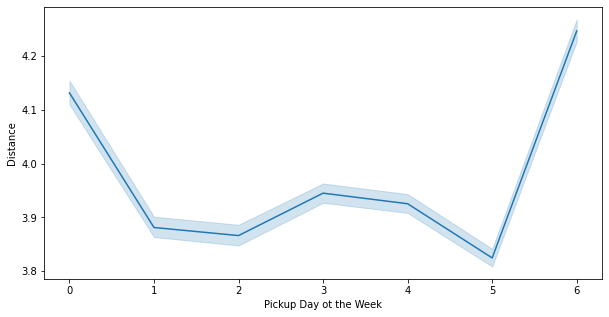

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x='pickup_weekday_num', y='distance',data=data)
plt.ylabel('Distance')
plt.xlabel('Pickup Day ot the Week')
plt.show()

*   So it's a fairly equal distribution with average distance metric verying around 3.5 km/h with Sunday being at the top may be due to outstation trips or night trips towards the airport.




**Distance and Month**

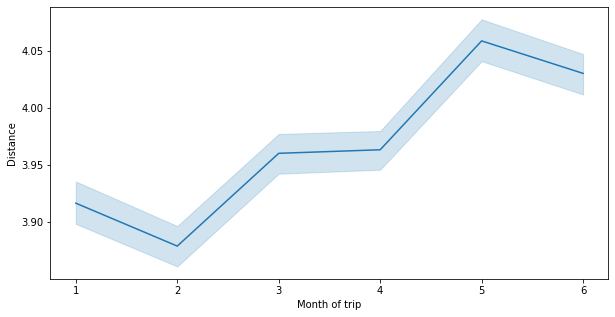

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x='month', y='distance',data=data)
plt.ylabel('Distance')
plt.xlabel('Month of trip')
plt.show()

*   As we already saw during trip duration per month, similarly trip distance is lowest in 2nd month and maximum in 5th month.



**Distance and Trip Duration**

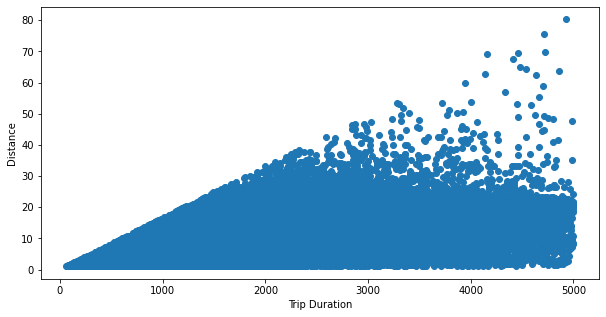

In [ ]:
plt.figure(figsize = (10,5))
plt.scatter(x='trip_duration', y='distance',data=data)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()


*   Initially there is some proper correlation between the distance covered and the trip duration in the graph, but later on it seems a little uncorrelated.



**Idea:**

---



We should remove those trips which covered 0 km distance.

In [ ]:
data = data[~(data.distance == 0)]

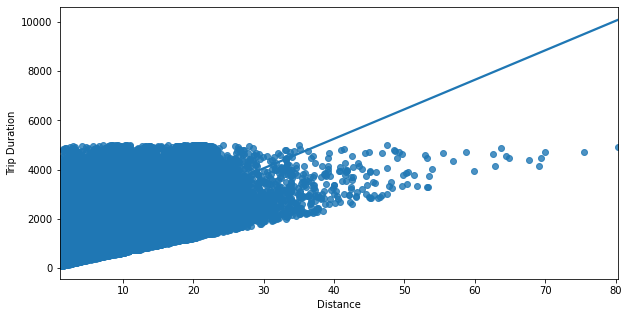

In [ ]:
plt.figure(figsize = (10,5))
sns.regplot(data.distance, data.trip_duration)
plt.ylabel('Trip Duration')
plt.xlabel('Distance')
plt.show()

*   The straight line shows some linear relation between the two.



# **Feature Engineering**

**One Hot Encoding**

Dummify features like 'store_and_fwd_flag', and 'pickup_weekday'.

In [ ]:
dummy = pd.get_dummies(data.store_and_fwd_flag, prefix='store_and_fwd_flag')
data = pd.concat([data,dummy], axis = 1)

In [ ]:
dummy = pd.get_dummies(data.pickup_weekday, prefix='pickup_weekday', drop_first=True)
data = pd.concat([data,dummy], axis = 1,)

Let's convert trip_duration in hours.

In [ ]:
data['trip_duration_hour']=data['trip_duration']/3600

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,dropoff_weekday,pickup_weekday_num,pickup_hour,month,distance,speed,pickup_timeofday,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_weekday_Monday,pickup_weekday_Saturday,pickup_weekday_Sunday,pickup_weekday_Thursday,pickup_weekday_Tuesday,pickup_weekday_Wednesday,trip_duration_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,0,17,3,1.498523,11.856445,Evening,1,0,1,0,0,0,0,0,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,0,6,1.805510,9.803673,Late night,1,0,0,0,1,0,0,0,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,1,11,1,6.385108,10.822216,Morning,1,0,0,0,0,0,1,0,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,2,19,4,1.485501,12.465739,Evening,1,0,0,0,0,0,0,1,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,5,13,3,1.188590,9.836608,Afternoon,1,0,0,1,0,0,0,0,0.120833


Let us remove the colmns which are not important for further analysis.

In [ ]:
data=data.drop(['id','pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag', 'pickup_weekday', 'dropoff_weekday', 'pickup_weekday_num', 'pickup_timeofday', 'trip_duration', 'speed'], axis=1)
data.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_hour,month,distance,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_weekday_Monday,pickup_weekday_Saturday,pickup_weekday_Sunday,pickup_weekday_Thursday,pickup_weekday_Tuesday,pickup_weekday_Wednesday,trip_duration_hour
0,2,1,-73.982155,40.767937,-73.964630,40.765602,17,3,1.498523,1,0,1,0,0,0,0,0,0.126389
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,6,1.805510,1,0,0,0,1,0,0,0,0.184167
2,2,1,-73.979027,40.763939,-74.005333,40.710087,11,1,6.385108,1,0,0,0,0,0,1,0,0.590000
3,2,1,-74.010040,40.719971,-74.012268,40.706718,19,4,1.485501,1,0,0,0,0,0,0,1,0.119167
4,2,1,-73.973053,40.793209,-73.972923,40.782520,13,3,1.188590,1,0,0,1,0,0,0,0,0.120833


In [ ]:
data.shape[1]

18

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1208841 entries, 0 to 1458643
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   vendor_id                 1208841 non-null  int64  
 1   passenger_count           1208841 non-null  int64  
 2   pickup_longitude          1208841 non-null  float64
 3   pickup_latitude           1208841 non-null  float64
 4   dropoff_longitude         1208841 non-null  float64
 5   dropoff_latitude          1208841 non-null  float64
 6   pickup_hour               1208841 non-null  int64  
 7   month                     1208841 non-null  int64  
 8   distance                  1208841 non-null  float64
 9   store_and_fwd_flag_N      1208841 non-null  uint8  
 10  store_and_fwd_flag_Y      1208841 non-null  uint8  
 11  pickup_weekday_Monday     1208841 non-null  uint8  
 12  pickup_weekday_Saturday   1208841 non-null  uint8  
 13  pickup_weekday_Sunday     1

In [ ]:
data.shape

(1208841, 18)

In [ ]:
data.isnull().sum()

vendor_id                   0
passenger_count             0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
pickup_hour                 0
month                       0
distance                    0
store_and_fwd_flag_N        0
store_and_fwd_flag_Y        0
pickup_weekday_Monday       0
pickup_weekday_Saturday     0
pickup_weekday_Sunday       0
pickup_weekday_Thursday     0
pickup_weekday_Tuesday      0
pickup_weekday_Wednesday    0
trip_duration_hour          0
dtype: int64

*   We don't have any missing values in our dataset.

# **Correlation Analysis**

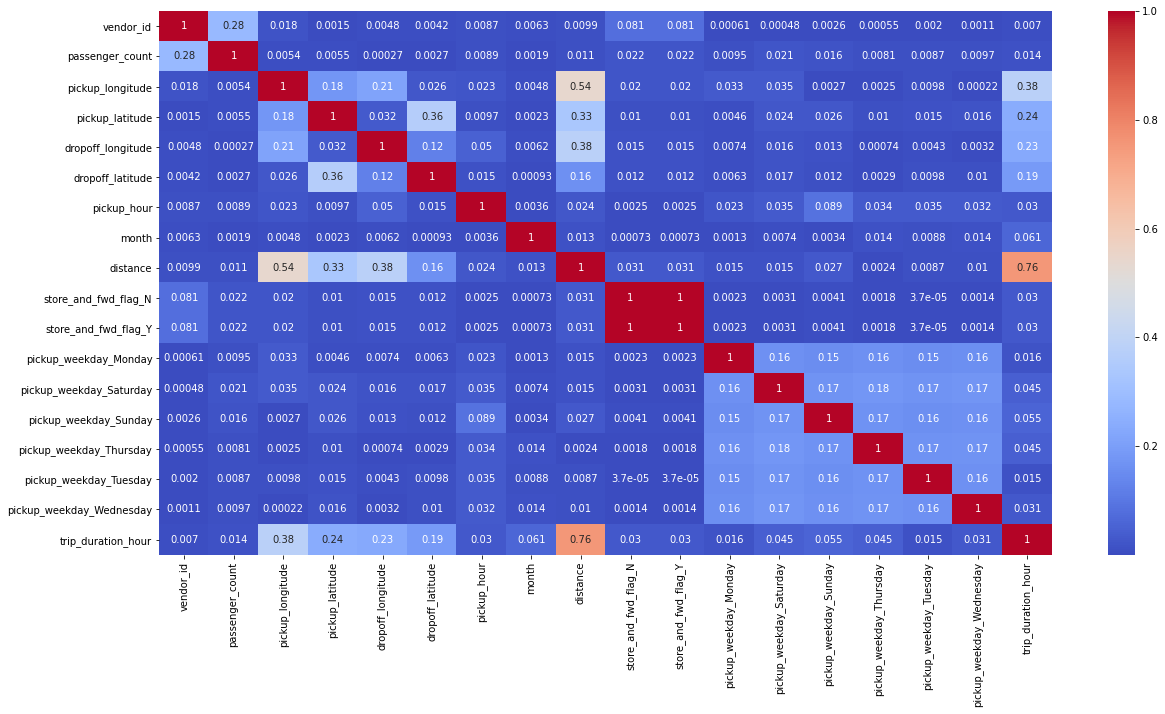

In [ ]:
plt.figure (figsize= (20,10))
corelation= data.corr()
sns.heatmap(abs(corelation), annot=True, cmap='coolwarm')

*   We can see store_and_fwd_flag_y and store_and_fwd_flag_N are highly correlated.  
*   Also they do not affect the target varible i.e. trip_duration_hour much. Hece we should remove these features from our dataset.
*   At the same time vendor_id doesn't affect much either so we can remove that as well.




In [ ]:
data=data.drop(['store_and_fwd_flag_N', 'store_and_fwd_flag_Y','vendor_id'], axis=1)

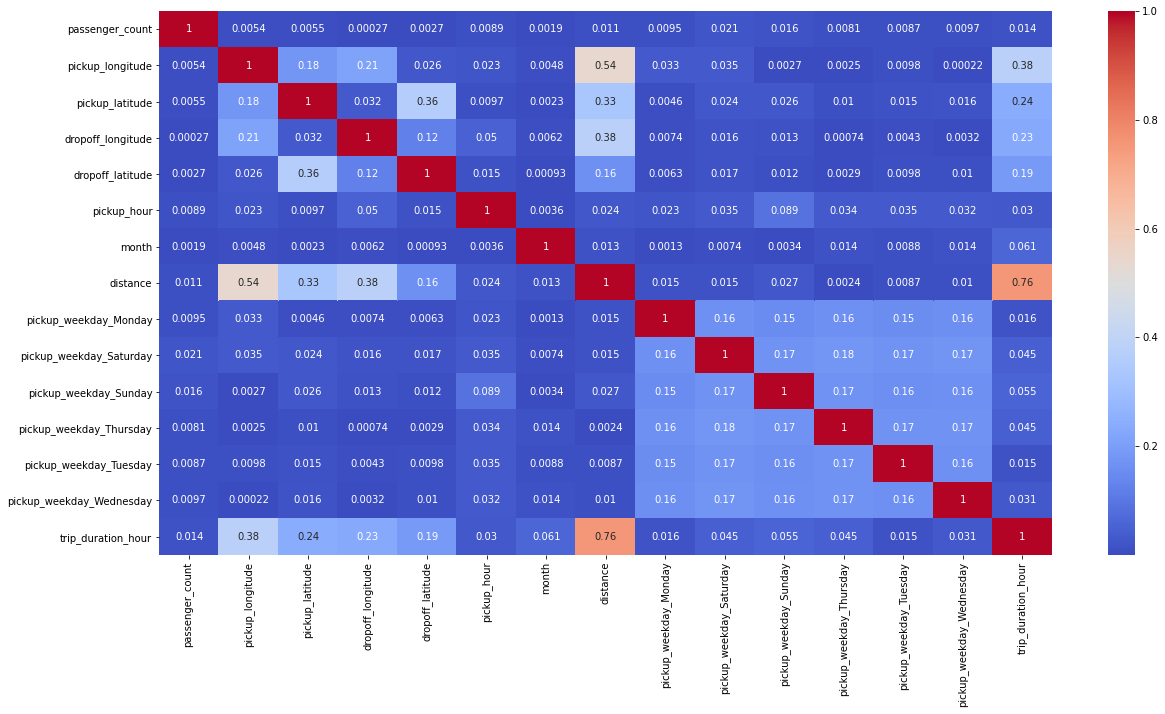

In [ ]:
plt.figure (figsize= (20,10))
corelation= data.corr()
sns.heatmap(abs(corelation), annot=True, cmap='coolwarm')

Let's check numerical features.


In [ ]:
numeric_features= data.describe().columns

In [ ]:
features= numeric_features.copy()
features= list(features)
features= features[:-1]
features

['passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'pickup_hour',
 'month',
 'distance',
 'pickup_weekday_Monday',
 'pickup_weekday_Saturday',
 'pickup_weekday_Sunday',
 'pickup_weekday_Thursday',
 'pickup_weekday_Tuesday',
 'pickup_weekday_Wednesday']

In [ ]:
len(features)

14



*   Since the data set has a lot of rows we will use the first only a portion of this for our training purpose.




In [ ]:
from scipy.stats import zscore
X = data[features].apply(zscore)[:]  

In [ ]:
 y= np.log10(data['trip_duration_hour'])[:]
 


# **Splitting the training in train and test sets**

In [ ]:
#Importing RFE and Linear Regression 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Splited the selected data set in 75-25 split for training and testing purpose respectively

**Recurssive Feature Elimination(RFE)**

RFE tries to select the features that are important and it eliminates the features that are not important.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
#Running RFE with output number of the variable  equals to 13
lm =  LinearRegression()
rfe = RFE(lm, n_features_to_select=12)
rfe= rfe.fit(X_train, y_train)
#printing the boolean result
rfe.support_

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True])

In [ ]:
#Assign the rfe features from X_train into col 
col= X_train.columns[rfe.support_]

# **Building Model using sklearn**

In [ ]:
#X_train_rfe is nothing but assigning remaining features after eliminating unimportant features from X_train
X_train_rfe= X_train[col]

In [ ]:
import statsmodels.api as sm
#Adding a constant variable
X_train_rfe= sm.add_constant(X_train_rfe)

**Running the Linear Model.**

In [ ]:
lm= sm.OLS(y_train, X_train_rfe).fit()

Let's see the summary of our linear model.

In [ ]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:     trip_duration_hour   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                 6.849e+04
Date:                Tue, 07 Sep 2021   Prob (F-statistic):               0.00
Time:                        11:50:23   Log-Likelihood:             1.8492e+05
No. Observations:              906630   AIC:                        -3.698e+05
Df Residuals:                  906617   BIC:                        -3.697e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
X_test.shape

(302211, 14)

# **Making Prediction**

Let's use our model to make prediction.

In [ ]:
#Making prediction
y_pred_train= lm.predict(X_train_rfe)

In [ ]:
X_test_rfe= X_test[col]
#Adding a condtant variable
X_test_rfe= sm.add_constant(X_test_rfe)

#Making prediction
y_pred_test= lm.predict(X_test_rfe)

# **Model Evaluation**

Now, let's check how well our model is able to make prediction.

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
lr_train_mse  = mean_squared_error((y_train), (y_pred_train))
print("Train MSE :" , lr_train_mse)

lr_train_rmse = np.sqrt(lr_train_mse)

print("Train RMSE :" ,lr_train_rmse)

lr_train_r2 = r2_score((y_train), (y_pred_train))
print("Train R2 :" ,lr_train_r2) 

lr_train_r2_ = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",lr_train_r2_)

Train MSE : 0.038936965572071776
Train RMSE : 0.19732451842604806
Train R2 : 0.4754827066161367
Train Adjusted R2 :  0.47547460699048816


In [ ]:
lr_test_mse  = mean_squared_error((y_test), (y_pred_test))
print("Test MSE :" , lr_test_mse)

lr_test_rmse = np.sqrt(lr_test_mse)

print("Test RMSE :" ,lr_test_rmse)

lr_test_r2 = r2_score((y_test), (y_pred_test))
print("Test R2 :" ,lr_test_r2)

lr_test_r2_ = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",lr_test_r2_)

Test MSE : 0.03900951174701119
Test RMSE : 0.19750825741475012
Test R2 : 0.47500151722035133
Test Adjusted R2 :  0.47497719532741123


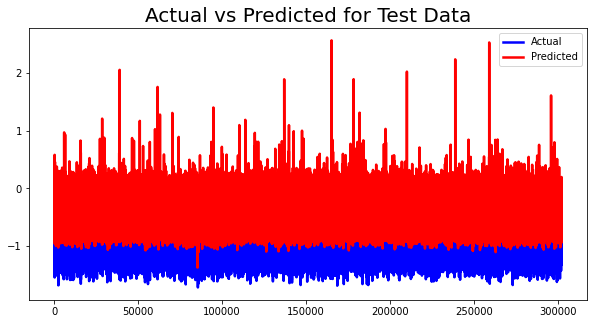

In [ ]:
#Actual vs Prediction
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred_test, color='red', linewidth=2.5, linestyle='-')
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

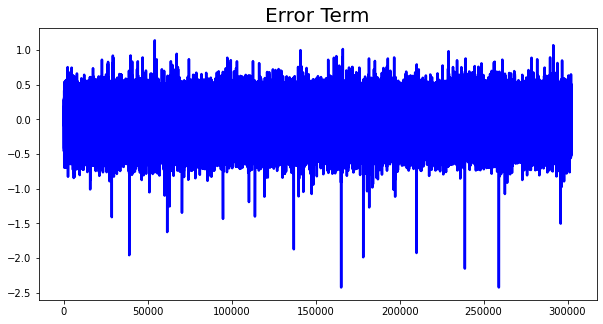

In [ ]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

As we can clearly see the Linear regression model does not provide us with high accuracy. It has high prediction error on the metrics we tested.

# **Running Lasso Regression**

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
#Cross validation
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [ ]:
print('The best fit alpha value is found out to be :', lasso_regressor.best_params_)
print('The R2 score using the same alpha is :', lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-08}
The R2 score using the same alpha is : 0.47552549860851184


In [ ]:
lasso_regressor.score(X_train, y_train)

0.4755640928302416

In [ ]:
y_pred_lasso_train = lasso_regressor.predict(X_train)

In [ ]:
y_pred_lasso_test = lasso_regressor.predict(X_test)

# **Model Evaluation**

In [ ]:
lasso_train_mse  = mean_squared_error(y_train, y_pred_lasso_train)
print("Train MSE :" , lasso_train_mse)

lasso_train_rmse = np.sqrt(lasso_train_mse)
print("Train RMSE :" ,lasso_train_rmse)

lasso_train_r2 = r2_score(y_train, y_pred_lasso_train)
print("Train R2 :" ,lasso_train_r2)

lasso_train_r2_= 1-(1-r2_score(y_train, y_pred_lasso_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", lasso_train_r2)

Train MSE : 0.03893092395579597
Train RMSE : 0.19730920899896176
Train R2 : 0.4755640928302416
Train Adjusted R2 :  0.4755640928302416


In [ ]:
lasso_test_mse  = mean_squared_error(y_test, y_pred_lasso_test)
print("Test MSE :" , lasso_test_mse)

lasso_test_rmse = np.sqrt(lasso_test_mse)
print("Test RMSE :" ,lasso_test_rmse)

lasso_test_r2 = r2_score(y_test, y_pred_lasso_test)
print("Test R2 :" ,lasso_test_r2)

lasso_test_r2_= 1-(1-r2_score(y_test, y_pred_lasso_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", lasso_test_r2_)

Test MSE : 0.039005133693539536
Test RMSE : 0.197497173887475
Test R2 : 0.47506043801497844
Test Adjusted R2 :  0.4750361188516944


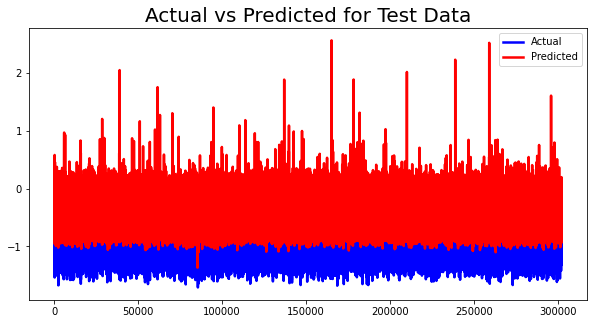

In [ ]:
#Actual vs Prediction
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred_lasso_test, color='red', linewidth=2.5, linestyle='-')
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

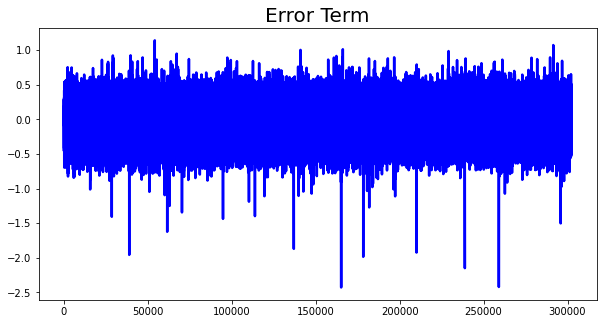

In [ ]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_lasso_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

The Lasso regresion model doesn't improve on the Linear model either.

# **Running Ridge Regression**

In [ ]:
from sklearn.linear_model import Ridge
#Cross validation
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='r2', cv=5)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [ ]:
print('The best fit alpha value is found out to be :' ,ridge_regressor.best_params_)
print('The R2 score using the same alpha is :', lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 40}
The R2 score using the same alpha is : 0.47552549860851184


In [ ]:
ridge_regressor.best_estimator_

Ridge(alpha=40, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [ ]:
ridge_regressor.score(X_train, y_train)

0.47556409027919333

In [ ]:
y_pred_ridge_train=ridge_regressor.predict(X_train)

In [ ]:
y_pred_ridge_test = ridge_regressor.predict(X_test)

# **Model Evaluation**

In [ ]:
ridge_train_mse  = mean_squared_error(y_train, y_pred_ridge_train)
print("Train MSE :" , ridge_train_mse)

ridge_train_rmse = np.sqrt(ridge_train_mse)
print("Train RMSE :" ,ridge_train_rmse)

ridge_train_r2 = r2_score(y_train, y_pred_ridge_train)
print("Train R2 :" ,ridge_train_r2)

ridge_train_r2_= 1-(1-r2_score(y_train, y_pred_ridge_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", ridge_train_r2)

Train MSE : 0.03893092414517024
Train RMSE : 0.1973092094788539
Train R2 : 0.47556409027919333
Train Adjusted R2 :  0.47556409027919333


In [ ]:
ridge_test_mse  = mean_squared_error(y_test, y_pred_ridge_test)
print("Test MSE :" , ridge_test_mse)

ridge_test_rmse = np.sqrt(ridge_test_mse)
print("Test RMSE :" ,ridge_test_rmse)

ridge_test_r2 = r2_score(y_test, y_pred_ridge_test)
print("Test R2 :" ,ridge_test_r2)

ridge_test_r2_= 1-(1-r2_score(y_test, y_pred_ridge_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", ridge_test_r2_)

Test MSE : 0.03900514294841856
Test RMSE : 0.19749719731788234
Test R2 : 0.47506031346080624
Test Adjusted R2 :  0.4750359942917519


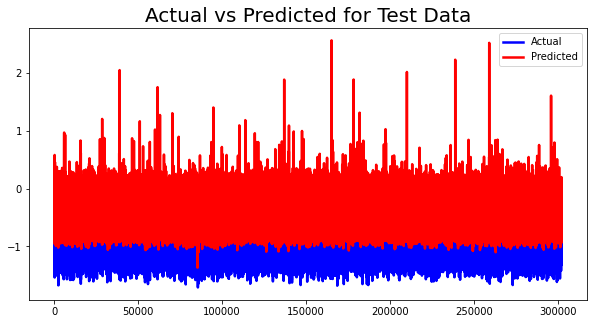

In [ ]:
#Actual vs Prediction
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred_ridge_test, color='red', linewidth=2.5, linestyle='-')
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

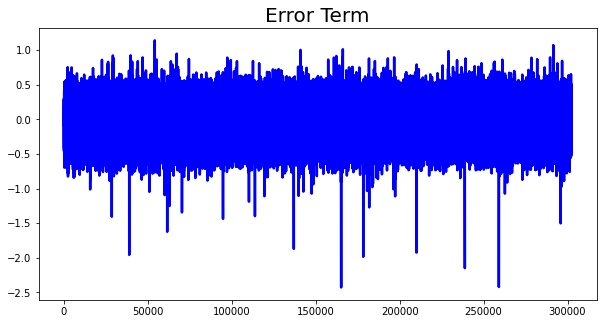

In [ ]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_ridge_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

The Ridge regresion model doesn't improve on the Linear model either.

# **Running Decision Tree Regressor**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Maximum depth of trees
max_depth = [4,6,8,10]
 
# Minimum number of samples required to split a node
min_samples_split = [10,20,30]
 
# Minimum number of samples required at each leaf node
min_samples_leaf = [8,16,22]
 
# Hyperparameter Grid
param_dict_dt = {
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}
#the cache variables contains the best parameters for the Decision Tree that we already tested before to save time when running again
cache = {
              'max_depth' : [10],
              'min_samples_split' : [10],
              'min_samples_leaf' : [22]}

In [ ]:
param_dict_dt

{'max_depth': [4, 6, 8, 10],
 'min_samples_leaf': [8, 16, 22],
 'min_samples_split': [10, 20, 30]}

In [ ]:
dt = DecisionTreeRegressor()

# Grid search
dt_grid = GridSearchCV(estimator=dt,
                       param_grid = cache,
                       cv = 5, verbose=2, scoring='r2')

dt_grid.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=10, min_samples_leaf=22, min_samples_split=10 .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, min_samples_leaf=22, min_samples_split=10, total=   5.0s
[CV] max_depth=10, min_samples_leaf=22, min_samples_split=10 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=22, min_samples_split=10, total=   5.0s
[CV] max_depth=10, min_samples_leaf=22, min_samples_split=10 .........
[CV]  max_depth=10, min_samples_leaf=22, min_samples_split=10, total=   5.0s
[CV] max_depth=10, min_samples_leaf=22, min_samples_split=10 .........
[CV]  max_depth=10, min_samples_leaf=22, min_samples_split=10, total=   5.0s
[CV] max_depth=10, min_samples_leaf=22, min_samples_split=10 .........
[CV]  max_depth=10, min_samples_leaf=22, min_samples_split=10, total=   5.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [10], 'min_samples_leaf': [22],
                         'min_samples_split': [10]},
             pre_dispatch='2*n_j

In [ ]:
dt_grid.best_score_

0.6970678826642874

In [ ]:
dt_grid.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=22, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_pred_dt_train=dt_grid.predict(X_train)

In [ ]:
y_pred_dt_test=dt_grid.predict(X_test)

# **Model Evaluation**

In [ ]:
dt_train_mse  = mean_squared_error(y_train, y_pred_dt_train)
print("Train MSE :" , dt_train_mse)

dt_train_rmse = np.sqrt(dt_train_mse)
print("Train RMSE :" ,dt_train_rmse)

dt_train_r2 = r2_score(y_train, y_pred_dt_train)
print("Train R2 :" ,dt_train_r2)

dt_train_r2_= 1-(1-r2_score(y_train, y_pred_dt_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", dt_train_r2_)

Train MSE : 0.02214210653085688
Train RMSE : 0.14880223967016384
Train R2 : 0.7017251443006
Train Adjusted R2 :  0.7017205383234435


In [ ]:
dt_test_mse  = mean_squared_error(y_test, y_pred_dt_test)
print("Test MSE :" , dt_test_mse)
dt_test_rmse = np.sqrt(dt_test_mse)
print("Test RMSE :" ,dt_test_rmse)

dt_test_r2 = r2_score(y_test, y_pred_dt_test)
print("Test R2 :" ,dt_test_r2)

dt_test_r2_= 1-(1-r2_score(y_test, y_pred_dt_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", dt_test_r2_)

Test MSE : 0.02245972267963721
Test RMSE : 0.14986568212782142
Test R2 : 0.697732173452168
Test Adjusted R2 :  0.69771817012462


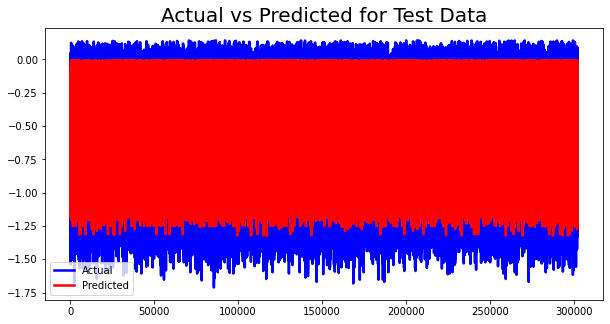

In [ ]:
#Actual vs Prediction
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred_dt_test, color='red', linewidth=2.5, linestyle='-')
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

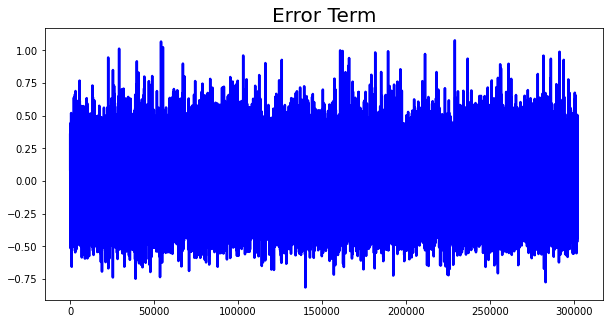

In [ ]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_dt_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

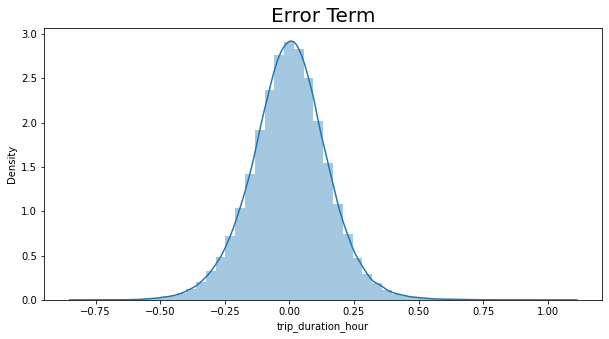

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(y_test - y_pred_dt_test )
plt.title('Error Term', fontsize=20)
plt.show()

The decision tree with the selected hyperparameters does improve the predictions of the model considerably. It still isn't ideal but it is certainly much better than Linear models. 

# **Running XGBoost Regressor**

In [ ]:
n_estimators = [80,150,200]
 
# Maximum depth of trees
max_depth = [5,8,10]
min_samples_split = [40,50]
learning_rate=[0.2,0.4,0.6]
 
# Hyperparameter Grid
param_xgb = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
             'min_samples_' : min_samples_split,
             'learning_rate' : learning_rate
             }
#the cache variables contains the best parameters for the XGBoost which we already tested before to save time when running it again.
cache = {'n_estimators' : [200],
              'max_depth' : [8],
             'min_samples_' : [40],
             'learning_rate' : [0.2],
             }

In [ ]:
param_xgb

{'learning_rate': [0.2, 0.4, 0.6],
 'max_depth': [5, 8, 10],
 'min_samples_': [40, 50],
 'n_estimators': [80, 150, 200]}

In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(tree_method = 'gpu_hist')

# Grid search
xgb_grid = GridSearchCV(estimator=xgb_model,
                        param_grid = cache,
                        cv = 3, verbose=1,
                        scoring="r2")

xgb_grid.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[11:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:54:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:54:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   53.1s finished


[11:55:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, tree_method='gpu_hist',
                                    verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.2], 'max_depth': [8],
     

In [ ]:
xgb_grid.best_score_

0.8108943501170421

In [ ]:
xgb_grid.best_params_

{'learning_rate': 0.2, 'max_depth': 8, 'min_samples_': 40, 'n_estimators': 200}

In [ ]:
y_pred_xgb_train=xgb_grid.predict(X_train)

In [ ]:
y_pred_xgb_test=xgb_grid.predict(X_test)

# **Model Evaluation**

In [ ]:
xgb_train_mse  = mean_squared_error(y_train, y_pred_xgb_train)
print("Train MSE :" , xgb_train_mse)

xgb_train_rmse = np.sqrt(xgb_train_mse)
print("Train RMSE :" ,xgb_train_rmse)

xgb_train_r2 = r2_score(y_train, y_pred_xgb_train)
print("Train R2 :" ,xgb_train_r2)

xgb_train_r2_= 1-(1-r2_score((y_train), (y_pred_xgb_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", xgb_train_r2_)

Train MSE : 0.012538065447470085
Train RMSE : 0.11197350332766268
Train R2 : 0.8311005478687377
Train Adjusted R2 :  0.831097939713865


In [ ]:
xgb_test_mse  = mean_squared_error(y_test, y_pred_xgb_test)
print("Test MSE :" , xgb_test_mse)

xgb_test_rmse = np.sqrt(xgb_test_mse)
print("Test RMSE :" ,xgb_test_rmse)

xgb_test_r2 = r2_score(y_test, y_pred_xgb_test)
print("Test R2 :" ,xgb_test_r2)

xgb_test_r2_= 1-(1-r2_score((y_test), (y_pred_xgb_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", xgb_test_r2_)

Test MSE : 0.013901535572477607
Test RMSE : 0.11790477332354957
Test R2 : 0.81291011455899
Test Adjusted R2 :  0.8129014471431533


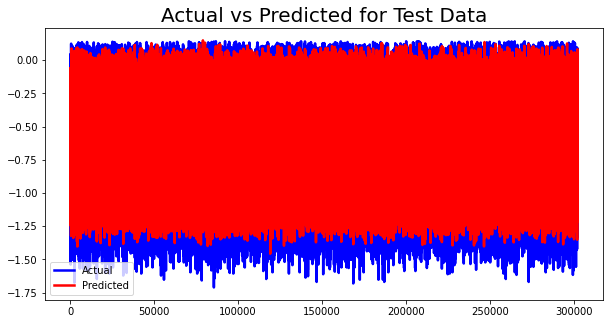

In [ ]:
#Actual vs Prediction
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test, color='blue', linewidth=2.5, linestyle='-')
plt.plot(c, y_pred_xgb_test, color='red', linewidth=2.5, linestyle='-')
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.legend(["Actual", "Predicted"])
plt.show()

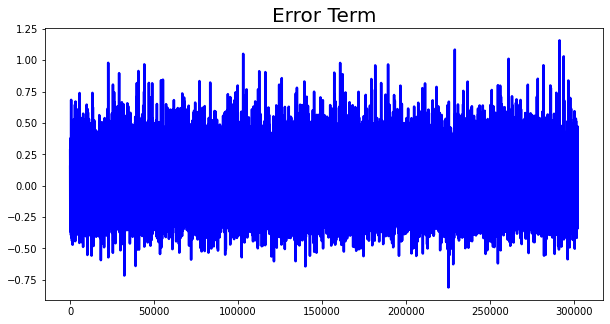

In [ ]:
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred_xgb_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

Finally, let's also look the feature importance.

In [ ]:
importance_df= pd.DataFrame({'Features': features, 'Feature_importance': list(xgb_grid.best_estimator_.feature_importances_)})
importance_df

,Features,Feature_importance
0,passenger_count,0.002280
1,pickup_longitude,0.018695
2,pickup_latitude,0.017836
3,dropoff_longitude,0.018719
4,dropoff_latitude,0.035818
5,pickup_hour,0.073304
6,month,0.011632
7,distance,0.567560
8,pickup_weekday_Monday,0.045675
9,pickup_weekday_Saturday,0.074935


In [ ]:
importance_df.sort_values(by=['Feature_importance'],ascending=False,inplace=True)

Let's look it by using bar grabh.

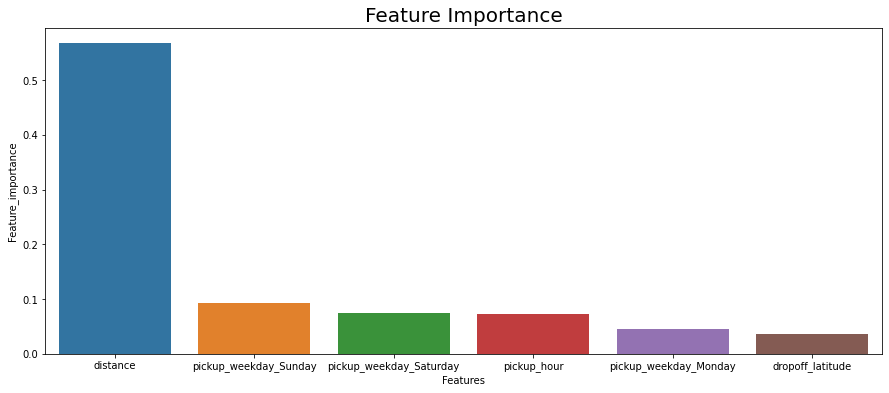

In [ ]:
plt.figure(figsize=(15,6))
plt.title('Feature Importance', fontsize=20)
sns.barplot(x='Features',y="Feature_importance", data=importance_df[:6])
plt.show()

Clearly, we can see distance is the top contributor to trip duration followed by different days of the weeks.

Plotting the error terms to understand the distribution.

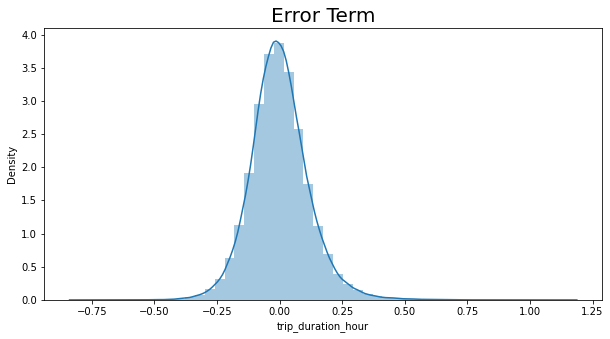

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(y_test - y_pred_xgb_test )
plt.title('Error Term', fontsize=20)
plt.show()


# **Evaluating the models**

**Models Summary for the Train data.**

In [ ]:
models= ['Linear Regression', 'Lasso Regression', 'Ridge Regression','DecisionTree Regressor','XGBoost Regressor']
train_mse= [lr_train_mse, lasso_train_mse, ridge_train_mse, dt_train_mse, xgb_train_mse]
train_rmse= [lr_train_rmse, lasso_train_rmse, ridge_train_rmse, dt_train_rmse, xgb_train_rmse]
train_r2= [lr_train_r2, lasso_train_r2, ridge_train_r2, dt_train_r2, xgb_train_r2]
train_adjusted_r2= [lr_train_r2_, lasso_train_r2_, ridge_train_r2_, dt_train_r2_, xgb_train_r2_]

**Models Summary for the test data.**


In [ ]:
models= ['Linear Regression', 'Lasso Regression', 'Ridge Regression','DecisionTree Regressor','XGBoost Regressor']
test_mse= [lr_test_mse, lasso_test_mse, ridge_test_mse, dt_test_mse, xgb_test_mse]
test_rmse= [lr_test_rmse, lasso_test_rmse, ridge_test_rmse, dt_test_rmse, xgb_test_rmse]
test_r2= [lr_test_r2, lasso_test_r2, ridge_test_r2, dt_test_r2, xgb_test_r2]
test_adjusted_r2= [lr_test_r2_, lasso_test_r2_, ridge_test_r2_, dt_test_r2_, xgb_test_r2_]

In [ ]:
Train_data_df=pd.DataFrame({'Model Name': models, 'Train MSE': train_mse, 'Train RMSE': train_rmse, 'Train R^2': train_r2, 
                            'Train Adjusted R^2': train_adjusted_r2})
Train_data_df

,Model Name,Train MSE,Train RMSE,Train R^2,Train Adjusted R^2
0,Linear Regression,0.038937,0.197325,0.475483,0.475475
1,Lasso Regression,0.038931,0.197309,0.475564,0.475556
2,Ridge Regression,0.038931,0.197309,0.475564,0.475556
3,DecisionTree Regressor,0.022142,0.148802,0.701725,0.701721
4,XGBoost Regressor,0.012538,0.111974,0.831101,0.831098


In [ ]:
Test_data_df= pd.DataFrame({'Model Name': models, 'Test MSE': test_mse, 'Test RMSE': test_rmse, 'Test R^2': test_r2, 
                            'Test Adjusted R^2': test_adjusted_r2})
Test_data_df

,Model Name,Test MSE,Test RMSE,Test R^2,Test Adjusted R^2
0,Linear Regression,0.039010,0.197508,0.475002,0.474977
1,Lasso Regression,0.039005,0.197497,0.475060,0.475036
2,Ridge Regression,0.039005,0.197497,0.475060,0.475036
3,DecisionTree Regressor,0.022460,0.149866,0.697732,0.697718
4,XGBoost Regressor,0.013902,0.117905,0.812910,0.812901


# **Conclusion**

*   We can see that MSE and RMSE which are the metrics used to evaluate the performance of regression model of **Decision Tree** and **XGBoost Regressor**  is not varying much during traing and testing time. Also the R^2 is about same during training and Testing time.
 
 
*   The Linear models don't show good performance on our training and testing environment.

 
 
 
 
*   From above table we can conclude  that **XGBoost Regressor** is the best models as compare to the other models to predict the trip duration for a particular taxi.